# 04 . PyTorch custom Datasets

## 0. Importing PyTorch and setting up device-agnostic code

In [ ]:
import torch
from torch import nn

In [ ]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

Our dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class(750 training ,250 testing).

Our dataset starts with 3 classes of food and only 10% of the images.

Why do this?

When starting our ML projects, it's important to try things on a small scale and then increase the scale when necessary.

The whole point is to speed up how fast you can experiment.

In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path/"pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exist...skipping download")
else:
  print(f"{image_path} does not exist, creating one ...")
  image_path.mkdir(parents=True,
                   exist_ok=True)
  
# Download pizza,steak and suhsi data
with open(data_path/"pizza_steak_sushi.zip","wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print(f"Downloading pizza ,stack,sushi data..")
  f.write(request.content)

# Unzip pizza,steak,sushi data
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip") as zip_ref:
  print("Unzip pizza,steak and sushi data.....")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist, creating one ...
Unzip pizza,steak and sushi data.....


## 2. Becoming one with the data(data preparation and dataexploration)

In [ ]:
import os

def walk_through_dir(dir_path):
  """ walks through dir_path returing its contents."""
  for dirpath,dirnames,filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} image in '{dirpath}'.")

In [ ]:
print(image_path)
walk_through_dir(image_path)

data/pizza_steak_sushi
There are 2 directories and 0 image in 'data/pizza_steak_sushi'.
There are 3 directories and 0 image in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 image in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 image in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 image in 'data/pizza_steak_sushi/train/steak'.
There are 3 directories and 0 image in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 image in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 image in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 image in 'data/pizza_steak_sushi/test/steak'.


In [ ]:
# Setup train and testing paths
train_dir = image_path/"train"
test_dir = image_path/"test"
train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing image

Let's write some code to:
1. Get all of the image paths

2. Pick a random image path using PyThon's `random.choice()`

3. Get the image class name using `pathlib.Path.parent.stem`

4. Since we're working with images,let's open the image with Python's PIL

5. we'll then show the image and print metadata

data/pizza_steak_sushi/train/pizza/300869.jpg
pizza
Random image path: data/pizza_steak_sushi/train/pizza/300869.jpg
Image class :pizza
Image Height: 384
Image width :512


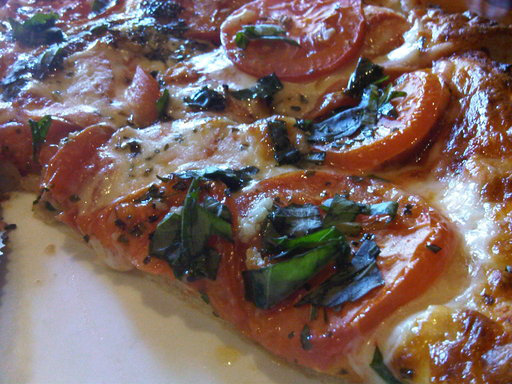

In [ ]:
import random
from PIL import Image

# Set Seed
random.seed(128)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name(the image class is the name of the directory where the image is stored)
image_class =random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metaData
print(f"Random image path: {random_image_path}")
print(f"Image class :{image_class}")
print(f"Image Height: {img.height}")
print(f"Image width :{img.width}")
img

(-0.5, 511.5, 383.5, -0.5)

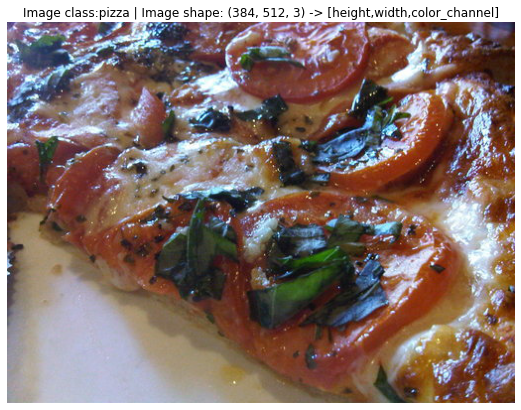

In [ ]:
# Visualize image using matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class:{image_class} | Image shape: {img_as_array.shape} -> [height,width,color_channel]")
plt.axis(False)

## 3. Transforming Data

Before we can use our image data with PyTorch

1. Turn your target data into tensors(in our case, numerical representation of our images)

2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`,
we'll call these Dataset and DataLoader 

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get our images ready to be used with a model/perform data augmentation.

In [ ]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [ ]:
data_transform(img).shape

torch.Size([3, 64, 64])

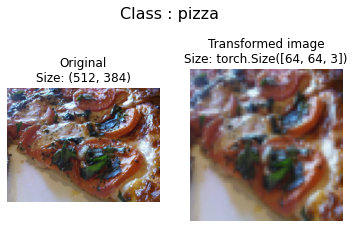

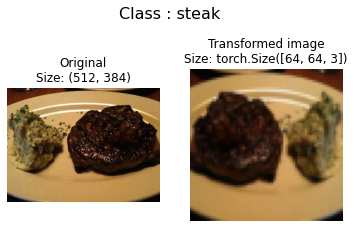

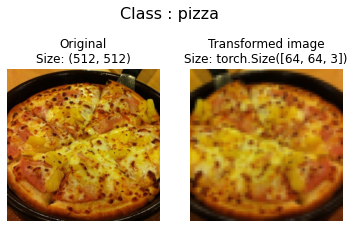

In [ ]:
def plot_transformed_images(image_paths,transform,n=3,seed=128):
  """
  Select random images from a path of images and loads/transforms
  them then plots the original vs the transformed version. 
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths,k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig,ax = plt.subplots(nrows=1,ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed image\nSize: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class : {image_path.parent.stem}",fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=128
                        )

## 4. Option 1:Loading image data using ImageFolder

We can load image classification data using `torchvision.datasets.ImageFolder`

In [ ]:
# Use ImageFolder to create dataset
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ), Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check the length of data
len(train_data),len(test_data)

(225, 75)

In [ ]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [ ]:
# Index on the train_data  Dataset to get a single image and label
img,label = train_data[0][0],train_data[0][1]

print(f"Image tensor shape:\n{img.shape}")
print(f"Image tensor label: {class_names[label]}")

Image tensor shape:
torch.Size([3, 64, 64])
Image tensor label: pizza


In [ ]:
class_names[label]

'pizza'

### 4.1 Turn loaded images into DataLoader's

A DataLoader is going to help us turn our Datasets's into iterable and we can customise the batch_size, so our model can see `batch_size` images at a time.

In [ ]:
# Turn train.utils.data import DataLoader's
from torch.utils.data import DataLoader

BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=False)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f180a8d5820>,
 <torch.utils.data.dataloader.DataLoader at 0x7f180a8d5880>)

In [ ]:
len(train_dataloader),len(test_dataloader)

(225, 75)

In [ ]:
img,label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} ->[batch_size,color_channels,height,width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) ->[batch_size,color_channels,height,width]
Label shape: torch.Size([1])


## 5 Option 2: Loading Image Data with a custom `dataset`

1. want to be able to load images from file.

2. want to be able to get class names from the Dataset

3. Want to be able to get classes as dictionary from the Dataset

Pros:

* Can create a Dataset out of almost anything

* Not limited to PyTorch prebuilt Dataset functions

Cons:

* Even though you could create `dataset` out of almost anything,
it doesn't mean it will work..

* Using a custom Dataset often results in us writing more code,which could be prone
to errors or performance issues

In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple,Dict,List


In [ ]:
# Instance of torchvision.dataset.ImageFolder()
train_data.classes,train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:

1. Get the class names using `os.scandir()` to traverse a target directory(ideally the directory is in standard image classification format).

2. Raise an error if the class names aren't found(if this happens,there might be something wrong with the directory structure).

3. Turn the class names into a dict and a list and return them.

In [ ]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [ ]:
def find_classes(directory:str) -> Tuple[List[str],Dict[str,int]]:

  """Finds the class folder names in a target directory."""

  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(target_directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... Please check file structure.")
  
  # 3. Create a dictionary of index labels(computers prefer numbers rather than strings as label)
  class_to_idx = {class_name: i for i,class_name in enumerate(classes)}
  return classes,class_to_idx

In [ ]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicat `ImageFolder`

To create our own custom dataset,we want to:

1. Subclass `torch.utils.data.Dataset`

2. Init our subclass with a target directory(the directory we'd like to get data from) as well as a transform if we'd like to transform our data.

3. Create several attributes:

  * paths - paths of our images
  
  * transform - the transform we'd like to use
  * classes - a list of the target classes

  * class_to_idx - a dict of the target classes mapped to integer labels

4. create a function to `load_images()`,this function will open an image

5. Overwrite the `__len__()` method to return the length of our dataset.

6. Overwrite the `__getitem__()` method to return a given sample when passed an index



In [ ]:
# 0. Write a custom datset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self,
               targ_dir:str,
               transform=None):
    # 3. Create class attributes
    #Get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))

    # Setup transform 
    self.transform = transform

    #Create classes and classes_to_idx attributes
    self.classes,self.class_to_idx = find_classes(targ_dir)
  
  # 4. Create a function to load images
  def load_image(self,index:int)->Image.Image:

    "Open an image via apath and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self)->int:
    "Returns the total number of sample."
    return len(self.paths)

  # 6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self,index:int) ->Tuple[torch.Tensor,int]:
    "Return one sample of data and label(x and y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg.
    class_idx = self.class_to_idx[class_name]

    #Transform if necessary
    if self.transform:
      return self.transform(img),class_idx # return data,label(x,y)

    else:
      return img,class_idx #return untransformed image and lebel

In [ ]:
# Create a transform
train_transforms = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [ ]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir= train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir= test_dir,
                                      transform=test_transforms)

train_data_custom,test_data_custom

(<__main__.ImageFolderCustom at 0x7f180a88a490>,
 <__main__.ImageFolderCustom at 0x7f180a88a670>)

In [ ]:
len(train_data),len(test_data)

(225, 75)

In [ ]:
len(train_data_custom),len(test_data_custom)

(225, 75)

In [ ]:
train_data_custom.classes,train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [ ]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustom dataset
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many image to visualize.
2. To prevent the display getting out of hand,let's cap the number of images to see at 10.
3. Set the random seed for reproducability.
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample images and plot them with matplotlib.
7. Make sure the dimension of our images line up with matplotlib


In [ ]:
# 1. create a function to take in a dataset
def display_random_images(dataset:torch.utils.data.Dataset,
                          classes:List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  
  # 2. Adjust display if n is too high
  if n>10:
    n = 10
    display_shape = False
    print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
  
  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_sample_idx = random.sample(range(len(dataset)),k=n)

  # 5. Setup plot
  plt.figure(figsize=(16,8))

  # 6. Loop through random indexes and plot them with matplotlib
  for i,targ_sample in enumerate(random_sample_idx):
    targ_image,targ_label = dataset[targ_sample][0],dataset[targ_sample][1]

    # 7. Adjust tensor dimension for plotting
    targ_image_adjust = targ_image.permute(1,2,0) #[C,H,W] ->[H,W,C]

    # Plot adjusted samples
    plt.subplot(1,n,i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class : {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    
    plt.title(title)


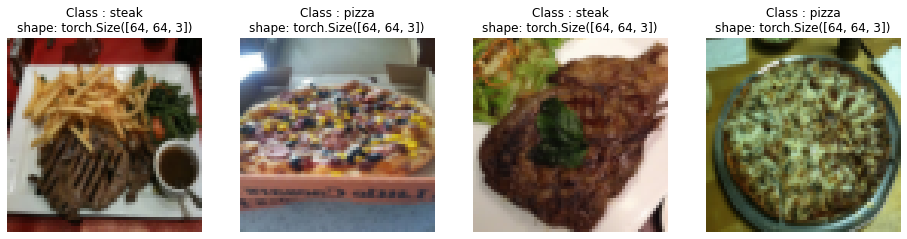

In [ ]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data,
                      n=4,
                      classes = class_names,
                      seed=None)

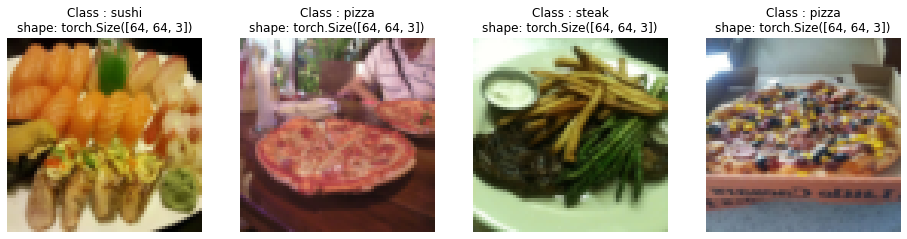

In [ ]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=4,
                      classes = class_names,
                      seed=None)

### 5.4 Turn custom loaded images into `DataLoader's`

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=os.cpu_count(),
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=os.cpu_count(),
                                     shuffle=False)

train_dataloader_custom,test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f1809deaa00>,
 <torch.utils.data.dataloader.DataLoader at 0x7f1809deaca0>)

In [ ]:
# Get image and label from custom dataloader
img_custom,label_custom = next(iter(train_dataloader_custom))

# Printout the shapes
img_custom.shape,label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms(data augmentation)

Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.

This practice hopefully results in a model that's more generalizable to unseen data.

So let's Look at one type of data augmentation used to train PyTorch vision models to state of the art levels Blog post : https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [ ]:
# Let's look at trivialaugment
from torchvision import transforms

train_transform = transforms.Compose([transforms.Resize(size=(224,224)),
                                      transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                      transforms.ToTensor()])

test_transform = transforms.Compose([transforms.Resize(size=(224,224)),
                                      transforms.ToTensor()])


In [ ]:
image_path

PosixPath('data/pizza_steak_sushi')

In [ ]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/sushi/1221830.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2175561.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/840444.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2004525.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/929471.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/542188.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2873571.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2492146.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/307738.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/3360232.jpg')]

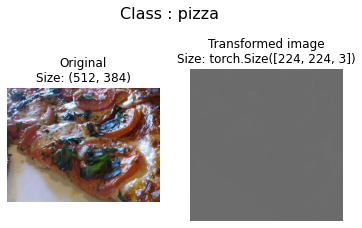

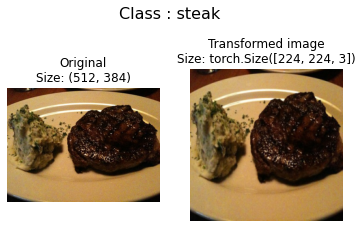

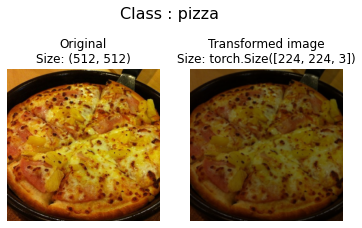

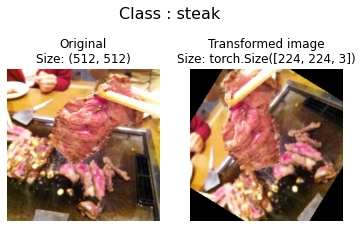

In [ ]:
# Plot random transformed images
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transform,
                        n=4,
                        seed = 128)

## 7. Model 0: TinyVGG without data augmentation

### 7.1 Creating transform and loading data for Model 0

In [ ]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [ ]:
# 1. Load and transform data

from torchvision import datasets

train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)

test_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)

# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of works
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoader's

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS
                                     )

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False,
                                     num_workers=NUM_WORKERS
                                     )


### 7.2 Create TinyVGG model class

In [ ]:
class TinyVGG(nn.Module):

  def __init__(self,
               input_shape:int,
               hidden_units:int,
               output_shape:int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=16*16*15,
                  out_features=output_shape)
    )

  def forward(self,x:torch.Tensor):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x

In [ ]:
torch.manual_seed(128)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=15,
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3840, out_features=3, bias=True)
  )
)

### 7.3 Try a forword pass on a single image(to test the model)

In [ ]:
# Get a single image batch
image_batch,label_batch = next(iter(train_dataloader_simple))
image_batch.shape,label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
# Try a forward pass
model_0(image_batch.to(device))

tensor([[-0.0113,  0.0071,  0.0165],
        [-0.0100,  0.0092,  0.0166],
        [-0.0117,  0.0121,  0.0192],
        [-0.0070,  0.0106,  0.0177],
        [-0.0091,  0.0086,  0.0213],
        [-0.0094,  0.0121,  0.0177],
        [-0.0086,  0.0119,  0.0164],
        [-0.0098,  0.0101,  0.0215],
        [-0.0075,  0.0125,  0.0182],
        [-0.0105,  0.0099,  0.0195],
        [-0.0108,  0.0070,  0.0181],
        [-0.0097,  0.0083,  0.0199],
        [-0.0109,  0.0106,  0.0208],
        [-0.0107,  0.0104,  0.0198],
        [-0.0102,  0.0087,  0.0148],
        [-0.0137,  0.0041,  0.0179],
        [-0.0104,  0.0085,  0.0162],
        [-0.0118,  0.0081,  0.0168],
        [-0.0115,  0.0088,  0.0165],
        [-0.0091,  0.0140,  0.0238],
        [-0.0108,  0.0111,  0.0184],
        [-0.0074,  0.0103,  0.0195],
        [-0.0102,  0.0111,  0.0197],
        [-0.0114,  0.0098,  0.0172],
        [-0.0106,  0.0094,  0.0172],
        [-0.0167,  0.0037,  0.0185],
        [-0.0079,  0.0101,  0.0164],
 

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0,input_size=[1,3,64,64])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 15, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 15, 64, 64]           420
│    └─ReLU: 2-2                         [1, 15, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 15, 64, 64]           2,040
│    └─ReLU: 2-4                         [1, 15, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 15, 32, 32]           --
├─Sequential: 1-2                        [1, 15, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 15, 32, 32]           2,040
│    └─ReLU: 2-7                         [1, 15, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 15, 32, 32]           2,040
│    └─ReLU: 2-9                         [1, 15, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 15, 16, 16]           --
├─Seq

## 7.5 Create train and test loops functions

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader.

* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader.

In [ ]:
def train_step(model:torch.nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device:torch.device):
  """Perform a training with model trying to learn on data_loader."""

  train_loss,train_acc= 0,0

  # Put model into training mode
  model.train()

  # Add a loop to loop through the training batches
  for batch,(x,y) in enumerate(data_loader):

    # Send the data to the target device
    x,y = x.to(device),y.to(device)

    # 1. Forward pass
    y_pred = model(x)

    # 2. Calculate loss
    loss = loss_fn(y_pred,y)
    train_loss += loss.item()

    # 3. Optimizer zero grade
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)


  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(data_loader)
  train_acc = train_acc / len(data_loader)

  return train_loss,train_acc


def test_step(model:torch.nn.Module,
              data_loader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              device:torch.device=device):
  """ Perform a testing loop step on model going over data_loader."""
  ## Testing
  test_loss,test_acc = 0,0

  model.eval()
  with torch.inference_mode():
    for x,y in data_loader:

      # Send the data to the target device
      x,y = x.to(device),y.to(device)

      # 1. Forword pass
      test_pred_logits = model(x)

      # 2. Calculate the loss(accumulatively)
      loss = loss_fn(test_pred_logits,y)
      test_loss +=loss.item()

      # 3. Calculate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels==y).sum().item()/len(test_pred_labels))


  # Calculate the test loss average per batch
  test_loss /= len(data_loader)

  # Calculate the test acc average per batch
  test_acc /= len(data_loader)

  return test_loss,test_acc

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [ ]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloaders + loss function
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_fn:torch.nn.Module = nn.CrossEntropyLoss(),
          epochs:int = 5,
          device = device):
  
  # 2. Create empty results dictionary
  results = {"train_loss":[],
             "train_acc":[],
             "test_loss":[],
             "test_acc":[]}
  
  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss,train_acc = train_step(model=model,
                                      data_loader=train_dataloader,
                                      loss_fn=loss_fn,
                                      optimizer=optimizer,
                                      device=device)
    test_loss,test_acc = test_step(model=model,
                                   data_loader=test_dataloader,
                                   loss_fn=loss_fn,
                                   device=device)
    
    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc:{train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(test_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  
  # 6. Return the filled results at the end of the epochs
  return results

### 7.7 Train and evaluate model0

In [ ]:
# Set random seeds
torch.manual_seed(128)

# Set Number of epochs
NUM_EPOCHS = 20



# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,
                  hidden_units=15,
                  output_shape=len(train_data.classes)).to(device)


# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.01)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer and print out how long it take
end_time = timer()
print(f"Total training time: {end_time-start_time:.5f} secound")




  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.2508 | Train acc:0.2969 | Test loss: 1.0985 | Test acc: 0.2930
Epoch: 1 | Train loss: 1.0977 | Train acc:0.3945 | Test loss: 1.1013 | Test acc: 0.2930
Epoch: 2 | Train loss: 1.1037 | Train acc:0.2930 | Test loss: 1.1035 | Test acc: 0.2930
Epoch: 3 | Train loss: 1.1024 | Train acc:0.2930 | Test loss: 1.1020 | Test acc: 0.2930
Epoch: 4 | Train loss: 1.0951 | Train acc:0.4141 | Test loss: 1.0996 | Test acc: 0.2930
Epoch: 5 | Train loss: 1.1055 | Train acc:0.2930 | Test loss: 1.1002 | Test acc: 0.2930
Epoch: 6 | Train loss: 1.0946 | Train acc:0.4141 | Test loss: 1.1015 | Test acc: 0.2930
Epoch: 7 | Train loss: 1.1021 | Train acc:0.2930 | Test loss: 1.1037 | Test acc: 0.2930
Epoch: 8 | Train loss: 1.0984 | Train acc:0.2930 | Test loss: 1.1053 | Test acc: 0.2930
Epoch: 9 | Train loss: 1.0940 | Train acc:0.4258 | Test loss: 1.1070 | Test acc: 0.3047
Epoch: 10 | Train loss: 1.0972 | Train acc:0.3047 | Test loss: 1.1086 | Test acc: 0.3047
Epoch: 11 | Train loss: 1.0966 

In [ ]:
16*16*15

3840

### 7.8 Plot the loss curves of Model 0

A **loss curve** is a way of tracking our model's progress over time.

A good guide for different loss curves can be seen here : https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

In [ ]:
# Get the model_0 _results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:


def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

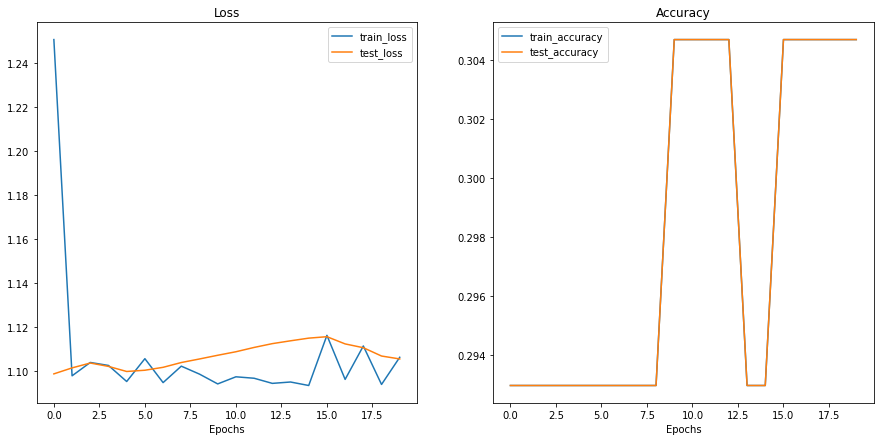

In [ ]:
plot_loss_curves(model_0_results)

## 9. Model 1: TinyVGG with Data Augmentation

Now let's try another modelling experiment this time using the same model as before with some data augmentation.


### 9.1 create training transform with data augmentation

In [ ]:
# create training transform with TrivialAugment
from torchvision import transforms

train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

### 9.2 Create train and test `Dataset's` and `DataLoader's` with data augmentation

In [ ]:
# Turn image folders into Datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform = test_transform_simple)

In [ ]:
# Turn our dataset into DataLoader
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
torch.manual_seed = 128

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle = False)

### 9.3 Construct and train model 1

This time we'll be using the same model architecture except this time we've augmented the training data.

In [ ]:
# Create model_1 and send it to the target device

# Set random seeds
torch.manual_seed=128

model_1 = TinyVGG(input_shape=3,
                  hidden_units=15,
                  output_shape=len(train_data_augmented.classes)
                  ).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3840, out_features=3, bias=True)
  )
)

In [ ]:
# Set random seeds
torch.manual_seed = 123

# Set Number of epochs
NUM_EPOCHS = 20

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.01)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer and print out how long it take
end_time = timer()
print(f"Total training time: {end_time-start_time:.5f} secound")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.0989 | Train acc:0.2930 | Test loss: 1.0992 | Test acc: 0.1979
Epoch: 1 | Train loss: 1.0990 | Train acc:0.2930 | Test loss: 1.0992 | Test acc: 0.1979
Epoch: 2 | Train loss: 1.0989 | Train acc:0.2891 | Test loss: 1.0992 | Test acc: 0.1979
Epoch: 3 | Train loss: 1.0991 | Train acc:0.2930 | Test loss: 1.0992 | Test acc: 0.1979
Epoch: 4 | Train loss: 1.0991 | Train acc:0.2891 | Test loss: 1.0992 | Test acc: 0.1979
Epoch: 5 | Train loss: 1.0989 | Train acc:0.2930 | Test loss: 1.0992 | Test acc: 0.1979
Epoch: 6 | Train loss: 1.0985 | Train acc:0.4141 | Test loss: 1.0992 | Test acc: 0.1979
Epoch: 7 | Train loss: 1.0980 | Train acc:0.4141 | Test loss: 1.0992 | Test acc: 0.1979
Epoch: 8 | Train loss: 1.0987 | Train acc:0.2891 | Test loss: 1.0992 | Test acc: 0.1979
Epoch: 9 | Train loss: 1.0983 | Train acc:0.4102 | Test loss: 1.0992 | Test acc: 0.1979
Epoch: 10 | Train loss: 1.0990 | Train acc:0.2930 | Test loss: 1.0992 | Test acc: 0.1979
Epoch: 11 | Train loss: 1.0991 

### 9.4 Plot the loss curves of model 1

A loss curve helps us to evaluate perfomence overtime

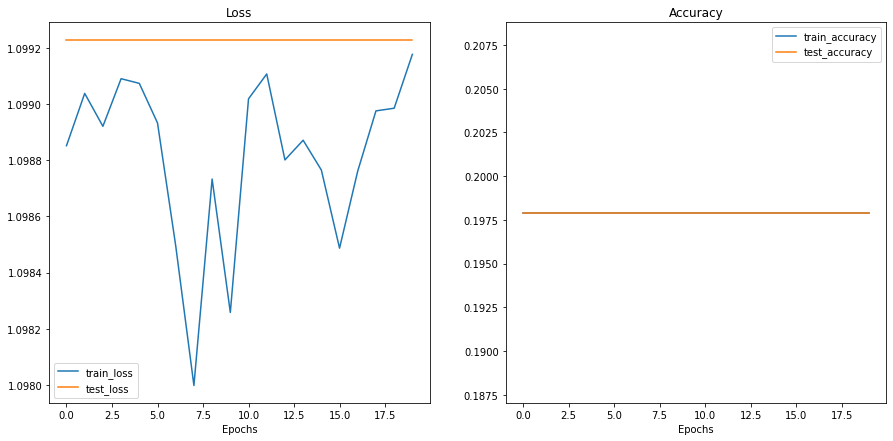

In [ ]:
plot_loss_curves(model_1_results)

## 10. Compare model results

After evaluating our modelling experiments on their own,it's importent to compare them to each other.

There's a few different ways to do this:

1. Hard coding(what we're doing)

2. PyTorch + Tensorboard 

3. Weight and bias - https://wandb.ai/site

4. MLFlow - https://mlflow.org/

In [ ]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.250838,0.292969,1.098549,0.292969
1,1.097666,0.292969,1.101277,0.292969
2,1.103747,0.292969,1.103491,0.292969
3,1.102389,0.292969,1.101951,0.292969
4,1.095073,0.292969,1.099641,0.292969
5,1.105470,0.292969,1.100208,0.292969
6,1.094571,0.292969,1.101537,0.292969
7,1.102063,0.292969,1.103722,0.292969
8,1.098438,0.292969,1.105339,0.292969
9,1.093974,0.304688,1.107026,0.304688


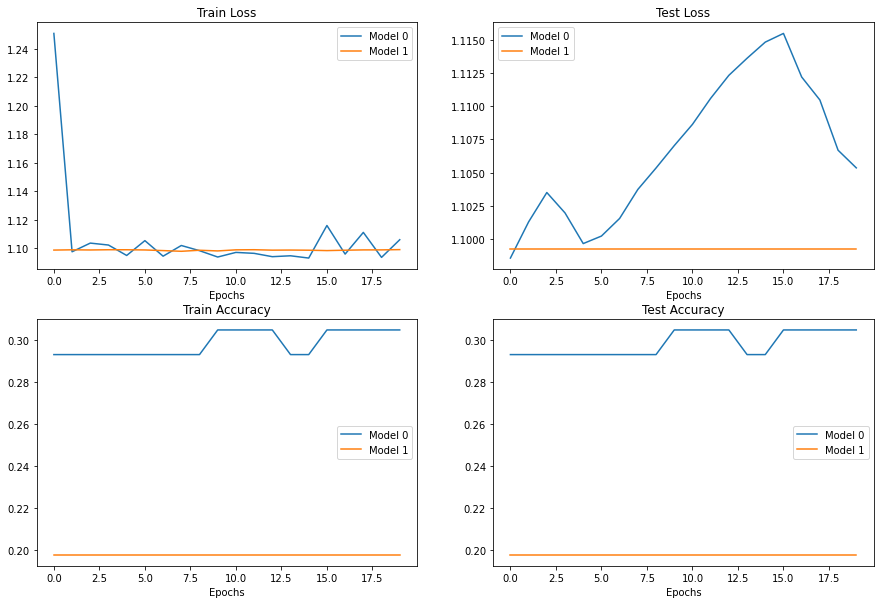

In [ ]:
# Setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

## 11. Making a prediction on a custom image

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

## 11.1 Loading in a custom image with PyTorch

We have to make sure our custom image isin the same format as the 
data our model was trained on.

* In tensor from with datatype(torch.flot32)
* Of shape 64x64x3
* On the right device

In [ ]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

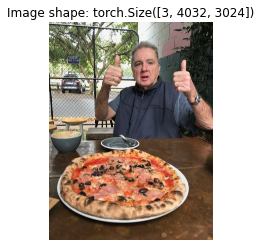

In [ ]:
# Plot custom image
plt.imshow(custom_image_uint8.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image_uint8.shape}")
plt.axis(False);

### 11.2 Making Predicting on custom images with a trained PyTorch model

In [ ]:
# Try to make a prediction on an image in uint8 format
model_1.eval()
with torch.inference_mode():
  model_1(custom_image_uint8.to(device))

RuntimeError: ignored

In [ ]:
# Load in the custom image and convert to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)/255
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

In [ ]:
custom_image.shape

torch.Size([3, 4032, 3024])

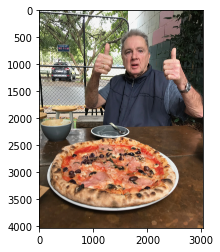

In [ ]:
plt.imshow(custom_image.permute(1, 2, 0))

In [ ]:
# Create transform pipeline to resize image
from torchvision import transforms
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64,64))
    ])

# Tranform target images
custom_image_transformed = custom_image_transform(custom_image)

# Print out the shaped
print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
Transformed shape: torch.Size([3, 64, 64])


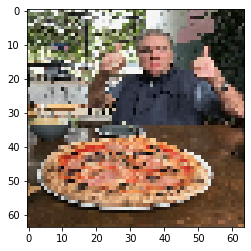

In [ ]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [ ]:
# This will error because no batch size
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.to(device))

RuntimeError: ignored

In [ ]:
custom_image_transformed.shape,custom_image_transformed.unsqueeze(0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [ ]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))

float32,
Note, to make a prediction on a custom image we had to:

* Load the image and turn it into a tensor.
* Make sure the image was the same datatype as the model(torch.float32)
* Make sure the was the same shape as the data the model was trained on (3,64,64) with a batch size(1,3,64,64)
* Make sure the image was on the same device as our model

In [ ]:
# Convert logits -> prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred,dim=1)
custom_image_pred_probs

tensor([[0.3325, 0.3348, 0.3327]], device='cuda:0')

In [ ]:
# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs,dim=1).cpu()
custom_image_pred_label

tensor([1])

In [ ]:
class_names[custom_image_pred_label]

'steak'

###  11.3 Putting custom image prediction together: building a function

Ideal outcome:

A function where we pass an image path to and have our model predict on that image and plot the image + prediction

In [ ]:
def pred_and_plot_image(model: torch.nn.Module, 
                        image_path: str, 
                        class_names: List[str] = None, 
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""
    
    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255. 
    
    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)
    
    # 4. Make sure the model is on the target device
    model.to(device)
    
    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)
    
        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))
        
    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

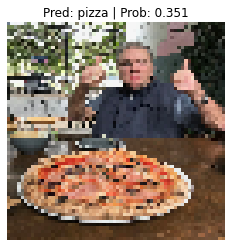

In [ ]:
# Pred on our custom image
pred_and_plot_image(model=model_0,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)